<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/3_Embeddings/2_Entrenamiento_Word2Vec.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Implementación del Entrenamiento de Word2Vec

Ahora que conocemos los detalles técnicos de los modelos word2vec y los métodos de entrenamiento aproximados, veamos sus implementaciones. Específicamente, tomaremos como ejemplo el modelo skip-gram con muestreo negativo.


# Cargando el Dataset

Para extraer la información de la Semántica Distribucional necesaria para entrenar embeddings en Español, usaremos el libro "El ingenioso hidalgo don Quijote de la Mancha". Cabe aclarar que este libro será usado solamente para que se entiendan las salidas de cada uno de los pasos de este proceso. En la práctica necesitamos un Dataset MUCHÍSIMO MÁS GRANDE para generar embeddings coherentes como la Wikipedia entera, pero eso llevaría mucho tiempo y no es el objetivo de esta clase.

Las siguientes celdas de código descargan el libro, leen el archivo en listas de oraciones y generan el vocabulario de torchtext como hemos hechos en clases anteriores.


In [ ]:
!pip install torchtext==0.15.2

In [ ]:
!wget https://www.gutenberg.org/files/2000/2000-0.txt
!mv "2000-0.txt" "quijote.txt"

--2024-10-14 16:10:29--  https://www.gutenberg.org/files/2000/2000-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2226045 (2.1M) [text/plain]
Saving to: ‘2000-0.txt’

2000-0.txt          100%[===================>]   2.12M  --.-KB/s    in 0.1s    

2024-10-14 16:10:29 (14.5 MB/s) - ‘2000-0.txt’ saved [2226045/2226045]



In [ ]:
def read_txt(filename, n_ignored):
    """
    Carga un archivo txt en una lista de oraciones.
    A su vez, cada oración es una lista de tokens separados por espacio.
    Ignora las primeras n_ignored lineas.
    """
    with open(filename) as f:
        raw_text = f.read()
    return [line.split() for i,line in enumerate(raw_text.split('\n')) if i>=n_ignored]

oraciones_quijote = read_txt("quijote.txt",28)

for i, oracion in enumerate(oraciones_quijote):
  if i > 10:break
  print(oracion)

['El', 'ingenioso', 'hidalgo', 'don', 'Quijote', 'de', 'la', 'Mancha']
[]
[]
[]
['por', 'Miguel', 'de', 'Cervantes', 'Saavedra']
[]
[]
[]
[]
[]
['El', 'ingenioso', 'hidalgo', 'don', 'Quijote', 'de', 'la', 'Mancha']


In [ ]:
import collections
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

def make_vocab(oraciones,min_freq=1):
  #Comprueba que oraciones es una lista de listas
  if oraciones and isinstance(oraciones[0], list):
    #Transforma una lista anidada en una lista simple
    tokens = [token for line in oraciones for token in line]
  counter_obj = collections.Counter()
  counter_obj.update(tokens)
  sorted_by_freq_tuples = sorted(counter_obj.items(), key=lambda x: x[1], reverse=True)
  ordered_dict = OrderedDict(sorted_by_freq_tuples)
  vocabulario = vocab(ordered_dict, min_freq=min_freq)
  return vocabulario, ordered_dict

vocab_completo, _ = make_vocab(oraciones_quijote)
vocab_min_freq_10, ordered_dict = make_vocab(oraciones_quijote,10)

print("El tamaño del vocabulario sin frecuencia mínima es",len(vocab_completo))
print("El tamaño del vocabulario con frecuencia mínima de 10 es",len(vocab_min_freq_10))

El tamaño del vocabulario sin frecuencia mínima es 39766
El tamaño del vocabulario con frecuencia mínima de 10 es 3241


## Subsampling

Los datos de texto suelen tener palabras de alta frecuencia como "el", "un" y "en": que incluso pueden aparecer miles de millones de veces en corpus muy grandes. Sin embargo, estas palabras a menudo coexisten con muchas palabras diferentes en las ventanas de contexto, proporcionando señales poco útiles. Por ejemplo, considere la palabra "chip" en una ventana de contexto: intuitivamente, su coexistencia con una palabra de baja frecuencia como "intel" es más útil en el entrenamiento que la coexistencia con una palabra de alta frecuencia como "el". Además, el entrenamiento con grandes cantidades de palabras (de alta frecuencia) es lento. Por lo tanto, al entrenar modelos de embedding de palabras, las de alta frecuencia se pueden submuestrear. Específicamente, cada palabra indexada $w_i$ en el conjunto de datos se descartará con probabilidad

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

donde $f(w_i)$ es la relación entre la cantidad de palabras $w_i$ y la cantidad total de palabras en el dataset, y la constante $t$ es un hiperparámetro ($10^{-4}$ en el experimento).
Podemos ver que solo cuando la frecuencia relativa $f(w_i) > t$ se puede descartar la palabra (de alta frecuencia) $w_i$, y cuanto mayor sea la frecuencia relativa de la palabra, mayor será la probabilidad de que se descarte.


La siguiente celda nos muestra las 10 palabras más frecuentes en el quijote. Como verán son palabras de relleno que pueden encajar en cualquier oración independientemente de sus significado y eso provee muy poco información a la semántia distribucional.

In [ ]:
def get_most_frequent_in_vocab(vocab, ordered_dic, n):
  return [(item,ordered_dic[item])
      for i, item in enumerate(ordered_dic)
      if vocab.__contains__(item) and i<n]

get_most_frequent_in_vocab(vocab_min_freq_10,ordered_dict,10)

[('que', 19546),
 ('de', 18132),
 ('y', 15976),
 ('la', 10329),
 ('a', 9627),
 ('el', 8009),
 ('en', 7941),
 ('no', 5620),
 ('se', 4751),
 ('los', 4701)]

La siguiente función elimina palabras frecuentes del dataset siguiendo la fórmula propuesta.

In [ ]:
import random
import math
def subsample(oraciones):
  """Subsample high-frequency words."""
  #Comprueba que oraciones es una lista de listas
  if oraciones and isinstance(oraciones[0], list):
    #Transforma una lista anidada en una lista simple
    tokens = [token for line in oraciones for token in line]
  counter_obj = collections.Counter()
  counter_obj.update(tokens)
  num_tokens = sum(counter_obj.values())

  # Devuelve true si hay que conservar el token
  def keep(token):
      return(random.uniform(0, 1) <
              math.sqrt(1e-4 / counter_obj[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in oraciones],
          counter_obj)


oraciones_quijote_subsampled, counter = subsample(oraciones_quijote)

El siguiente fragmento de código traza el histograma del número de tokens por oración antes y después del submuestreo. Como era de esperar, el submuestreo acorta significativamente las oraciones al eliminar las palabras de alta frecuencia, lo que acelerará el entrenamiento.


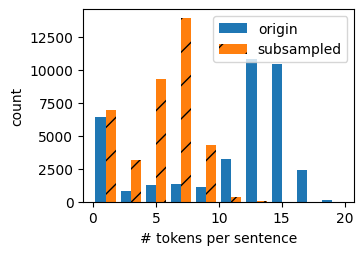

In [ ]:
from matplotlib import pyplot as plt

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    plt.rcParams['figure.figsize'] = (3.5, 2.5)
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', oraciones_quijote, oraciones_quijote_subsampled);

Para fichas individuales, la frecuencia de muestreo de la palabra de alta frecuencia "que" es inferior a 1/20.


In [ ]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in oraciones_quijote])}, '
            f'after={sum([l.count(token) for l in oraciones_quijote_subsampled])}')

compare_counts('que')

'# of "que": before=19546, after=920'

Por el contrario, las palabras de baja frecuencia como "mesa" se mantienen por completo.


In [ ]:
compare_counts('mesa')

'# of "mesa": before=16, after=16'

Después del submuestreo, asignamos índices a los tokens y así generamos el corpus.

In [ ]:
corpus = [[vocab_min_freq_10[x] for x in line if vocab_min_freq_10.__contains__(x)]
          for line in oraciones_quijote_subsampled if line != []]
corpus[:3]

[[1388, 684, 44, 735], [1655, 2950], [1388, 735]]

## Extracción de palabras centrales y palabras de contexto

La siguiente función get_centers_and_contexts extrae todas las palabras centrales y sus palabras de contexto del corpus. Muestrea uniformemente un número entero entre 1 y max_window_size al azar como el tamaño de la ventana de contexto. Para cualquier palabra central, aquellas palabras cuya distancia no exceda el tamaño de la ventana de contexto muestreada son sus palabras de contexto.

In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
  """Return center words and context words in skip-gram."""
  centers, contexts = [], []
  for line in corpus:
    # Para formar un par de "palabra central--palabra de contexto",
    # cada oración debe tener al menos 2 palabras
    if len(line) < 2:
      continue
    centers += line
    for i in range(len(line)):  # Ventana de contexto centrada en `i`
      window_size = random.randint(1, max_window_size)
      indices = list(range(max(0, i - window_size),
                            min(len(line), i + 1 + window_size)))
      # Excluir la palabra central de las palabras de contexto
      indices.remove(i)
      contexts.append([line[idx] for idx in indices])
  return centers, contexts

A continuación, para ilustrar su funcionamiento, creamos un conjunto de datos artificial que contiene dos oraciones de 7 y 3 palabras, respectivamente. Haremos que el tamaño máximo de la ventana de contexto sea 2 e imprimiremos todas las palabras centrales y sus palabras de contexto.


In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


En este ejercicios, estableceremos el tamaño máximo de la ventana de contexto en 5. La siguiente celda extrae del todas las palabras centrales y sus palabras de contexto.


In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 303726'

## Muestreo negativo

Usamos muestreo negativo para entrenamiento aproximado. Para muestrear palabras negativas de acuerdo con una distribución predefinida, definimos la siguiente clase RandomGenerator, donde la distribución de muestreo (posiblemente no normalizada) se pasa a través del argumento sampling_weights.


In [ ]:
class RandomGenerator:
  """Randomly draw among {1, ..., n} according to n sampling weights."""
  def __init__(self, sampling_weights):
    # Exclude
    self.population = list(range(1, len(sampling_weights) + 1))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0

  def draw(self):
    if self.i == len(self.candidates):
      # Cache `k` random sampling results
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000)
      self.i = 0
    self.i += 1
    return self.candidates[self.i - 1]


Para un par de palabra central y palabra de contexto, muestreamos aleatoriamente `K` (5 en el experimento) palabras negativas. Según las sugerencias del paper de word2vec, la probabilidad de muestreo $P(w)$ de una palabra negativa $w$ se establece en su frecuencia relativa en el diccionario elevada a la potencia de 0,75.



In [ ]:
def get_negatives(all_contexts, vocab, counter, K):
    """Devuelve palabras ruidosas para muestreo negativo."""
    # Pesos de muestreo para palabras con índices 1, 2, ...
    # (índice 0 es el token <unk> excluido) en el vocabulario
    tokens = vocab.get_itos()
    sampling_weights = [counter[tokens[i]]**0.75
                        for i in range(1, len(tokens))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Las palabras ruidosas no pueden ser de contexto
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab_min_freq_10, counter, 5)

In [ ]:
all_centers[500], all_contexts[500], all_negatives[500]

(21, [40, 610], [3, 1233, 81, 2980, 106, 5, 619, 120, 2, 1574])

## Cargando ejemplos de entrenamiento en minilotes

Una vez extraídas todas las palabras centrales junto con sus palabras de contexto y las palabras negativas muestreadas, transformaremos los datos en minilotes de ejemplos que se pueden cargar de forma iterativa durante el entrenamiento.

En un minilote, el ejemplo $i^\mathrm{th}$ incluye una palabra central, sus palabras de contexto $n_i$ y palabras negativas $m_i$. Debido a los diferentes tamaños de ventana de contexto, $n_i+m_i$ varía para diferentes $i$.
Por lo tanto, para cada ejemplo, concatenamos sus palabras de contexto y palabras negativas en la variable `contexts_negatives` y rellenamos con ceros hasta que la longitud de la concatenación alcance $\max_i n_i+m_i$ (`max_len`).
Para excluir los rellenos en el cálculo de la pérdida, definimos una variable de máscara `mask`. Hay una correspondencia de uno a uno entre los elementos en `mask` y los elementos en `context_negative`, donde los ceros (de lo contrario unos) en `mask` corresponden a rellenos en `context_negative`.


Para distinguir entre ejemplos positivos y negativos, separamos las palabras de contexto de las palabras negativas en contexts_negatives a través de una variable labels. De forma similar a las máscaras, también existe una correspondencia uno a uno entre los elementos de las etiquetas y los elementos de los contextos_negativos, donde los unos (de lo contrario, los ceros) de las etiquetas corresponden a las palabras de contexto en contexts_negatives.

La idea anterior se implementa en la siguiente función `collate_batch`. Sus datos de entrada son una lista con una longitud igual al tamaño del lote, donde cada elemento es un ejemplo que consta de la palabra central `center`, sus palabras de contexto `context` y sus palabras negativas `negative`. Esta función devuelve un minilote que se puede cargar para realizar cálculos durante el entrenamiento, como incluir la variable de máscara.


In [ ]:
import torch
def collate_batch(data):
  max_len = max(len(c) + len(n) for _, c, n in data)
  centers, contexts_negatives, masks, labels = [], [], [], []
  for center, context, negative in data:
    centers += [center]
    cur_len = len(context) + len(negative)
    contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]
  return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

Probemos esta función usando un mini lote de dos ejemplos.

In [ ]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = collate_batch((x_1, x_2))

names = ['centers', 'contexts_negatives', 'lengths', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
lengths = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## Juntar todo

Por último, definimos la función `load_data_quijote` que lee el quijote y devuelve el iterador de datos y el vocabulario.


In [ ]:
def load_data_quijote(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    oraciones_quijote = read_txt("quijote.txt",28)
    vocabulario, ordered_dict = make_vocab(oraciones_quijote,10)
    oraciones_quijote_subsampled, counter = subsample(oraciones_quijote)
    corpus = [[vocabulario[x] for x in line if vocabulario.__contains__(x)]
          for line in oraciones_quijote_subsampled if line != []]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocabulario, counter, num_noise_words)

    class QuijoteDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = QuijoteDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=collate_batch)
    return data_iter, vocabulario

Imprimamos el primer minilote del iterador de datos.


In [ ]:
data_iter, vocabulario = load_data_quijote(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 42])
lengths shape: torch.Size([512, 42])
labels shape: torch.Size([512, 42])


# Proceso de Entrenamiento

Implementamos el modelo skip-gram mediante el uso de capas `Embedding` y multiplicaciones de matrices por lotes.
Primero, revisemos cómo funcionan las capas Embedding.


### Embedding Layer

Una capa embedding asigna el índice de un token a su vector de características.
Los pesos de estas capas conforman una matriz cuyo número de filas es igual al tamaño del diccionario (`input_dim`) y el número de columnas es igual a
la dimensión del vector para cada token (`output_dim`).
Después de entrenar un modelo de embedding de palabras, estos peso se convertiran en el embedding que utilizaremos para representar a la palabra


In [ ]:
from torch import nn
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parametro embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parametro embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


La entrada de una capa Embedding es el índice de un token (palabra). Para cualquier índice de token i, su representación vectorial se puede obtener de la i-ésima fila de la matriz de pesos en la capa de Embedding. Dado que la dimensión del vector (output_dim) se estableció en 4, la capa de Embedding devuelve vectores con forma (2, 3, 4) para un minilote de índices de token con forma (2, 3).


In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.4101,  0.7336, -1.3830, -0.5934],
         [-0.7240, -2.4424, -0.0161,  1.6716],
         [-2.5373, -0.2425, -1.3210,  0.3728]],

        [[-0.4331, -0.5432,  0.3439, -0.3248],
         [ 0.9710,  0.4140,  0.3033,  0.5695],
         [ 1.3535, -0.8945, -0.6488,  0.6080]]], grad_fn=<EmbeddingBackward0>)

### Parámetros del Modelo

Al comienzo de la fase de entrenamiento, creamos dos matrices: una matriz de embedding y una matriz de contexto. Estas dos matrices tienen un embedding de palabra central y de contexto respectivamente para cada palabra en nuestro vocabulario.

![Imgur](https://i.imgur.com/YY2jU6Q.png)

En nuestro modelo, estas matrices estarán definidas como capas Embedding y la dimensión de los vectores será 100.


In [ ]:
embed_size = 100
central_embedding = nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size)
context_embedding = nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size)
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocabulario),
                                 embedding_dim=embed_size))

### Definición de la función forward

En la función forward, la entrada del modelo skip-gram incluye a `center` (los índices de la palabra central con forma (tamaño del lote, 1)) y `contexts_and_negatives` (los indices concatenados de las palabras de contexto y negativas con forma (tamaño del lote, max_len) ).

Estas dos variables se transforman primero de los índices de token en vectores a través de la capa de Embedding

![Imgur](https://i.imgur.com/qjIjDZN.png)

Luego se calcula el producto punto entre el vector de la palabra central por cada uno de los vectores de contexto y negativos usando una multiplicación de matrices por lotes. Cada elemento de la salida es el producto escalar de un vector de palabra central y un vector de palabra de contexto o negativa.

![Imgur](https://i.imgur.com/vWco0hG.png)

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, central_embedding, context_embedding):
      super().__init__()
      self.central_embedding = central_embedding
      self.context_embedding = context_embedding

    def forward(self, center, contexts_and_negatives):
      v = central_embedding(center)
      u = context_embedding(contexts_and_negatives)
      pred = torch.bmm(v, u.permute(0, 2, 1))
      return pred

Imprimamos la forma de la salida de este SkipGram para algunas entradas de ejemplo

In [ ]:
model = SkipGram(central_embedding, context_embedding)
model(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long)).shape

torch.Size([2, 1, 4])

## Entrenamiento


Una vez que tenemos la función forward, el proceso de entrenamiento es similar a los modelos vistos con anterioridad: se calcula la función de pérdida y eso se utiliza para modificar los parámetros. La particularidad del entrenamiento de embeddings es que los embeddings que queremos obtener como salida son los mismos parámetros que estamos entrenando.

![Imgur](https://i.imgur.com/PpgE131.png)





## Función de pérdida

De acuerdo a la definición de la función de pérdida para muestreo negativo que presentamos anteriormente
usaremos la entropía cruzada binaria (también conocida como sigmoidea).

In [ ]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

Si probamos con algunos datos inventados.


In [ ]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

Vemos que los mismos resultados se pueden generar usando la función sigmoidea (aunque de manera menos eficiente.

Podemos considerar a las dos salidas como dos pérdidas normalizadas que se promedian sobre las predicciones no enmascaradas.


In [ ]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


## Definición del ciclo de entrenamiento

El ciclo de entrenamiento se define a continuación. Debido a la existencia de relleno, el cálculo de la función de pérdida es ligeramente diferente en comparación con las funciones de entrenamiento anteriores.


In [ ]:
import time
def train(net, data_iter, lr, num_epochs, device):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    L = 0
    N = 0
    for epoch in range(num_epochs):
        start, num_batches = time.time(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = net(center, context_negative)
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            L += l.sum()
            N += l.numel()
        print(f'loss {L / N:.3f}, '
          f'{N / (time.time() - start):.1f} tokens/sec on {str(device)}')

Ahora podemos entrenar un modelo skip-gram usando muestreo negativo.


In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

lr, num_epochs = 0.002, 20
train(model, data_iter, lr, num_epochs, try_gpu())

loss 0.543, 14170.7 tokens/sec on cpu
loss 0.491, 31814.8 tokens/sec on cpu
loss 0.471, 42675.8 tokens/sec on cpu
loss 0.457, 63980.7 tokens/sec on cpu
loss 0.446, 69068.8 tokens/sec on cpu
loss 0.435, 82162.7 tokens/sec on cpu
loss 0.424, 114441.4 tokens/sec on cpu
loss 0.413, 112890.1 tokens/sec on cpu
loss 0.402, 143665.9 tokens/sec on cpu
loss 0.392, 142436.8 tokens/sec on cpu
loss 0.382, 178498.9 tokens/sec on cpu
loss 0.373, 172101.7 tokens/sec on cpu
loss 0.365, 179354.1 tokens/sec on cpu
loss 0.357, 231155.9 tokens/sec on cpu
loss 0.350, 210757.0 tokens/sec on cpu
loss 0.343, 253801.7 tokens/sec on cpu
loss 0.337, 242164.0 tokens/sec on cpu
loss 0.331, 276100.8 tokens/sec on cpu
loss 0.326, 288756.4 tokens/sec on cpu
loss 0.320, 275302.2 tokens/sec on cpu


## Aplicación de Embeddings de Palabras

Después de entrenar el modelo word2vec, podemos usar la similitud de coseno de los vectores de palabras del modelo entrenado para encontrar palabras del diccionario que sean más similares semánticamente a una palabra de entrada.

Recordemos que estamos entrenado sobre un dataset muy pequeño y los resultados no deberían ser muy buenos.


In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    assert vocabulario.__contains__(query_token), "El token no está en el vocabulario"
    x = W[vocabulario[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    tokens = vocabulario.get_itos()
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {tokens[i]}')

get_similar_tokens('hombre', 3, net[0])

cosine sim=0.346: caballero.
cosine sim=0.329: morir,
cosine sim=0.311: do
